In [1]:
# Install Kaggle API
!pip install -q kaggle

In [ ]:
# Upload your kaggle.json file
from google.colab import files
files.upload() # Uploaded the file

In [3]:
# Set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Download dataset
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 968MB/s]


In [5]:
# Unzip main archive
!unzip -q fruit-images-for-object-detection.zip -d fruit_data

## 0. Installing Dependencies

In [6]:
!pip install -q xmltodict torch torchvision onnx onnxruntime matplotlib opencv-python-headless pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## 1. Imports & Seeds

In [22]:
import os, glob, random, time, math, xmltodict, sys
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import onnx

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## 2. Paths & VOC XML parser

In [8]:
# Adjust these to your Colab paths
TRAIN_ROOT = "/content/fruit_data/train_zip/train"
TEST_ROOT  = "/content/fruit_data/test_zip/test"

def parse_voc_xml(xml_path):
    # returns list of objects with bbox and class, and original image path/dims
    with open(xml_path, 'r', encoding='utf-8') as f:
        ann = xmltodict.parse(f.read())['annotation']
    img_path = xml_path.replace('.xml', '.jpg')
    if not os.path.exists(img_path):
        # try .jpeg
        alt = xml_path.replace('.xml', '.jpeg')
        if os.path.exists(alt):
            img_path = alt
        else:
            return []
    img = Image.open(img_path).convert('RGB')
    iw, ih = img.size
    objs = ann.get('object', [])
    if objs is None:
        return []
    if isinstance(objs, dict):
        objs = [objs]
    out = []
    for o in objs:
        name = o['name']
        box = o['bndbox']
        xmin = int(box['xmin']); ymin = int(box['ymin'])
        xmax = int(box['xmax']); ymax = int(box['ymax'])
        # clamp
        xmin = max(0, min(iw-1, xmin)); xmax = max(0, min(iw-1, xmax))
        ymin = max(0, min(ih-1, ymin)); ymax = max(0, min(ih-1, ymax))
        w = max(1, xmax - xmin + 1); h = max(1, ymax - ymin + 1)
        cx = (xmin + xmax) / 2.0; cy = (ymin + ymax) / 2.0
        out.append({
            'name': name, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax,
            'w': w, 'h': h, 'cx': cx, 'cy': cy,
            'img_path': img_path, 'img_w': iw, 'img_h': ih
        })
    return out

def build_items(folder):
    xmls = sorted(glob.glob(os.path.join(folder, "*.xml")))
    items = []
    for x in xmls:
        parsed = parse_voc_xml(x)
        if not parsed:
            continue
        # simple: pick largest bbox per image (single-object model)
        best = max(parsed, key=lambda o: o['w'] * o['h'])
        items.append(best)
    return items

train_items = build_items(TRAIN_ROOT)
test_items  = build_items(TEST_ROOT)
print("Train items:", len(train_items), "Test items:", len(test_items))

# compute classes
CLASSES = sorted(list({it['name'] for it in train_items}))
class2idx = {c:i for i,c in enumerate(CLASSES)}
print("Classes:", CLASSES)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train items: 240 Test items: 60
Classes: ['apple', 'banana', 'orange']


## 3. Dataset & DataLoader (IMG_SIZE=64)

In [9]:
IMG_SIZE = 64   # micro variant
BATCH = 16      # reduce if you run out of memory

class FruitBBoxDataset(Dataset):
    def __init__(self, items, img_size=IMG_SIZE, transforms=None):
        self.items = items
        self.img_size = img_size
        self.transforms = transforms
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it['img_path']).convert('RGB')
        iw, ih = img.size
        # normalized bbox targets (relative to original)
        cx = it['cx'] / iw
        cy = it['cy'] / ih
        w = it['w'] / iw
        h = it['h'] / ih
        target_reg = np.array([cx, cy, w, h], dtype=np.float32)
        target_cls = class2idx[it['name']]
        if self.transforms:
            img = self.transforms(img)
        else:
            img = T.Resize((self.img_size, self.img_size))(img)
            img = T.ToTensor()(img)
        return img, torch.from_numpy(target_reg), torch.tensor(target_cls, dtype=torch.long)

# transforms
train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12, hue=0.02),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])
val_tf = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])

train_ds = FruitBBoxDataset(train_items, img_size=IMG_SIZE, transforms=train_tf)
val_ds   = FruitBBoxDataset(test_items,  img_size=IMG_SIZE, transforms=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Example batch:", next(iter(train_loader))[0].shape)


Example batch: torch.Size([16, 3, 64, 64])


## 4. Micro-model definition (exact design from earlier math)

In [10]:
class MicroTinyDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # tiny conv backbone: 3->8->12->16
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),    # 32x32
            nn.Conv2d(8, 12, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),    # 16x16
            nn.Conv2d(12, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),    # 8x8
            nn.AdaptiveAvgPool2d(1)  # -> (16,1,1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32), nn.ReLU()
        )
        # bbox head
        self.bbox_head = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 4), nn.Sigmoid()
        )
        # class head
        self.cls_head = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        bbox = self.bbox_head(x)
        cls_logits = self.cls_head(x)
        return bbox, cls_logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MicroTinyDetector(num_classes=len(CLASSES)).to(device)
print(model)
# quick param count
total_params = sum(p.numel() for p in model.parameters())
print("Total params:", total_params)


MicroTinyDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=1)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): ReLU()
  )
  (bbox_head): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
    (3): Sigmoid()
  )
  (cls_head): Sequential(
    (0): Linear(in_features=32, ou

## 5. Loss, optimizer, metrics

In [11]:
bbox_loss_fn = nn.SmoothL1Loss()
cls_loss_fn  = nn.CrossEntropyLoss()
# emphasize bbox more if you want better IoU:
BBOX_WEIGHT = 2.0   # you can tune (1.0 -> 3.0)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)

def bbox_to_xyxy(b):
    cx,cy,w,h = b[...,0], b[...,1], b[...,2], b[...,3]
    x1 = cx - w/2; y1 = cy - h/2
    x2 = cx + w/2; y2 = cy + h/2
    return x1, y1, x2, y2

def iou_batch(boxes1, boxes2, eps=1e-8):
    x11, y11, x12, y12 = bbox_to_xyxy(boxes1)
    x21, y21, x22, y22 = bbox_to_xyxy(boxes2)
    xi1 = torch.max(x11, x21); yi1 = torch.max(y11, y21)
    xi2 = torch.min(x12, x22); yi2 = torch.min(y12, y22)
    iw = (xi2 - xi1).clamp(min=0); ih = (yi2 - yi1).clamp(min=0)
    inter = iw * ih
    area1 = (x12 - x11).clamp(min=0) * (y12 - y11).clamp(min=0)
    area2 = (x22 - x21).clamp(min=0) * (y22 - y21).clamp(min=0)
    union = area1 + area2 - inter + eps
    return (inter / union).clamp(0,1)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 6. Train & Validate loops

In [12]:
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for imgs, regs, cls in train_loader:
        imgs = imgs.to(device); regs = regs.to(device); cls = cls.to(device)
        optimizer.zero_grad()
        pred_regs, pred_logits = model(imgs)
        loss_reg = bbox_loss_fn(pred_regs, regs)
        loss_cls = cls_loss_fn(pred_logits, cls)
        loss = BBOX_WEIGHT * loss_reg + loss_cls
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(train_loader.dataset)

@torch.no_grad()
def validate():
    model.eval()
    total_loss = 0.0
    iou_list = []
    correct = 0; total = 0
    for imgs, regs, cls in val_loader:
        imgs = imgs.to(device); regs = regs.to(device); cls = cls.to(device)
        pred_regs, pred_logits = model(imgs)
        loss_reg = bbox_loss_fn(pred_regs, regs)
        loss_cls = cls_loss_fn(pred_logits, cls)
        loss = BBOX_WEIGHT * loss_reg + loss_cls
        total_loss += loss.item() * imgs.size(0)
        ious = iou_batch(pred_regs, regs)
        iou_list.append(ious.cpu().numpy())
        preds = pred_logits.argmax(dim=1)
        correct += (preds == cls).sum().item(); total += imgs.size(0)
    mean_loss = total_loss / len(val_loader.dataset)
    mean_iou = float(np.concatenate(iou_list).mean()) if iou_list else 0.0
    acc = correct / total if total>0 else 0.0
    scheduler.step(mean_loss)
    return mean_loss, mean_iou, acc

# Training run
EPOCHS = 30
best_val = 1e9; no_improve = 0; patience = 8

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss = train_one_epoch()
    val_loss, val_iou, val_acc = validate()
    t1 = time.time()
    print(f"Epoch {ep:02d}  train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_iou={val_iou:.4f}  val_acc={val_acc:.3f}  time={(t1-t0):.1f}s")
    if val_loss < best_val - 1e-4:
        best_val = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "micro_best_tiny_detector.pth")
        print("  saved best")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping")
            break

# load best
model.load_state_dict(torch.load("micro_best_tiny_detector.pth", map_location=device))
print("Loaded best weights.")


Epoch 01  train_loss=1.1313  val_loss=1.1313  val_iou=0.3917  val_acc=0.350  time=4.6s
  saved best
Epoch 02  train_loss=1.1230  val_loss=1.1258  val_iou=0.4147  val_acc=0.350  time=4.9s
  saved best
Epoch 03  train_loss=1.1102  val_loss=1.1179  val_iou=0.4501  val_acc=0.350  time=2.6s
  saved best
Epoch 04  train_loss=1.0983  val_loss=1.1114  val_iou=0.4821  val_acc=0.350  time=2.6s
  saved best
Epoch 05  train_loss=1.0895  val_loss=1.1065  val_iou=0.4942  val_acc=0.367  time=2.6s
  saved best
Epoch 06  train_loss=1.0619  val_loss=1.0824  val_iou=0.4677  val_acc=0.500  time=3.5s
  saved best
Epoch 07  train_loss=1.0428  val_loss=1.0514  val_iou=0.4907  val_acc=0.383  time=2.8s
  saved best
Epoch 08  train_loss=1.0028  val_loss=0.9980  val_iou=0.4916  val_acc=0.517  time=2.5s
  saved best
Epoch 09  train_loss=0.9608  val_loss=0.9817  val_iou=0.4956  val_acc=0.533  time=2.9s
  saved best
Epoch 10  train_loss=0.9222  val_loss=0.9258  val_iou=0.4974  val_acc=0.617  time=2.8s
  saved best


In [13]:
import matplotlib.patches as patches

def predict_and_visualize_image_path(image_path, show=True):
    model.eval()
    pil = Image.open(image_path).convert('RGB')
    orig_w, orig_h = pil.size
    inp = val_tf(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_reg, pred_logits = model(inp)
        pred_reg = pred_reg[0].cpu().numpy()
        probs = torch.softmax(pred_logits[0], dim=0).cpu().numpy()
        cls_idx = int(probs.argmax()); conf = float(probs.max())
    # convert to pixel coords (original image scale)
    cx_n, cy_n, w_n, h_n = pred_reg
    cx_p = cx_n * orig_w; cy_p = cy_n * orig_h
    w_p = w_n * orig_w; h_p = h_n * orig_h
    xmin = int(round(max(0, cx_p - w_p/2))); ymin = int(round(max(0, cy_p - h_p/2)))
    xmax = int(round(min(orig_w-1, cx_p + w_p/2))); ymax = int(round(min(orig_h-1, cy_p + h_p/2)))
    pred_box = [xmin, ymin, xmax, ymax]
    # GT if xml exists
    xml_path = os.path.splitext(image_path)[0] + ".xml"
    gt = None
    if os.path.exists(xml_path):
        try:
            parsed = parse_voc_xml(xml_path)
            if parsed:
                best = max(parsed, key=lambda o: o['w']*o['h'])
                gt_box = [best['xmin'], best['ymin'], best['xmax'], best['ymax']]
                gt_name = best['name']
                # compute iou:
                def iou(a,b):
                    xA = max(a[0], b[0]); yA = max(a[1], b[1])
                    xB = min(a[2], b[2]); yB = min(a[3], b[3])
                    interW = max(0, xB-xA); interH = max(0, yB-yA)
                    interArea = interW * interH
                    areaA = max(0, a[2]-a[0]) * max(0, a[3]-a[1])
                    areaB = max(0, b[2]-b[0]) * max(0, b[3]-b[1])
                    union = areaA + areaB - interArea + 1e-8
                    return interArea / union
                iou_val = iou(pred_box, gt_box)
                gt = (gt_box, gt_name, iou_val)
        except Exception as e:
            print("GT parse error:", e)

    if show:
        img_np = np.array(pil)
        fig, ax = plt.subplots(1,1,figsize=(6,6))
        ax.imshow(img_np); ax.axis('off')
        rect_p = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2]-pred_box[0], pred_box[3]-pred_box[1],
                                   linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect_p)
        ax.text(pred_box[0], max(0,pred_box[1]-6), f"{CLASSES[cls_idx]} {conf:.2f}", color='white',
                bbox=dict(facecolor='red', alpha=0.6, pad=1), fontsize=10)
        if gt:
            rect_t = patches.Rectangle((gt[0][0], gt[0][1]), gt[0][2]-gt[0][0], gt[0][3]-gt[0][1],
                                       linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect_t)
            ax.text(gt[0][0], max(0, gt[0][1]-20), f"GT: {gt[1]}", color='white',
                    bbox=dict(facecolor='green', alpha=0.6, pad=1), fontsize=9)
            ax.set_title(f"Pred: {CLASSES[cls_idx]} ({conf:.2f})  IoU: {gt[2]:.3f}")
        else:
            ax.set_title(f"Pred: {CLASSES[cls_idx]} ({conf:.2f})  (no GT)")
        plt.show()
    return {
        'pred_class': CLASSES[cls_idx],
        'pred_conf': conf,
        'pred_bbox_pixels': pred_box,
        'pred_bbox_norm': [float(cx_n), float(cy_n), float(w_n), float(h_n)],
        'gt': gt
    }




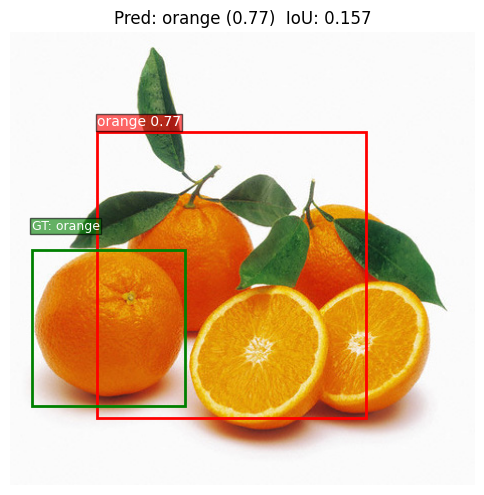

{'pred_class': 'orange', 'pred_conf': 0.7734640836715698, 'pred_bbox_pixels': [86, 99, 353, 383], 'pred_bbox_norm': [0.47478532791137695, 0.5352529287338257, 0.5784292817115784, 0.6296903491020203], 'gt': ([21, 216, 173, 371], 'orange', 0.15697938372348383)}


In [20]:
res = predict_and_visualize_image_path("/content/fruit_data/test_zip/test/orange_87.jpg")
print(res)

## 8. Export to ONNX

In [21]:
# Export the micro-model to ONNX for conversion pipeline
model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
ONNX_FNAME = "micro_tiny_detector.onnx"
torch.onnx.export(
    model, dummy, ONNX_FNAME,
    input_names=["input"],
    output_names=["bbox", "logits"],
    opset_version=11,
    dynamic_axes={"input": {0: "batch_size"}, "bbox": {0: "batch_size"}, "logits": {0: "batch_size"}},
)
print("Exported ONNX:", ONNX_FNAME, "size:", os.path.getsize(ONNX_FNAME), "bytes")


Exported ONNX: micro_tiny_detector.onnx size: 22037 bytes


## 9. Model Info.

In [23]:
# Config / filenames
MODEL_PTH = "micro_best_tiny_detector.pth"
TRACED_PT = "micro_tiny_detector_traced.pt"
ONNX_FNAME = "micro_tiny_detector.onnx"
TFLITE_FNAME = "micro_tiny_detector_int8.tflite"  # may not exist yet
IMG_SIZE = globals().get("IMG_SIZE", 64)
INPUT_SHAPE = (1, 3, IMG_SIZE, IMG_SIZE)
MCU_RAM_BYTES = 256 * 1024  # 256 KB for Nano 33 BLE Sense

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti']:
        if abs(num) < 1024.0:
            return f"{num:3.2f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.2f} Pi{suffix}"

# 1) Architecture and parameter counts
print("\n== Model architecture ==\n")
print(model)   # textual architecture

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal params: {total_params:,}  (trainable: {trainable_params:,})")
print(f"Approx weights size (float32): {sizeof_fmt(total_params * 4)}")
print(f"Approx weights size (int8): {sizeof_fmt(total_params * 1)}")

# 2) Save traced model (try) and show file sizes
print("\n== File sizes ==\n")
# Try to trace (if not already traced)
try:
    # put model on cpu for tracing to avoid GPU-specific ops in saved file
    model_cpu = model.eval().cpu()
    dummy = torch.randn(*INPUT_SHAPE)
    traced = torch.jit.trace(model_cpu, dummy)
    traced.save(TRACED_PT)
    traced_saved = True
except Exception as e:
    print("Tracing failed (not a big deal):", e)
    traced_saved = os.path.exists(TRACED_PT)

def finfo(p):
    p = Path(p)
    if p.exists():
        return (True, p.stat().st_size, sizeof_fmt(p.stat().st_size))
    else:
        return (False, None, "-")

pth_info = finfo(MODEL_PTH)
tr_info  = finfo(TRACED_PT)
onnx_info= finfo(ONNX_FNAME)
tflite_info = finfo(TFLITE_FNAME)

rows = [
    ("PyTorch .pth", MODEL_PTH, pth_info[0], pth_info[2]),
    ("Traced .pt", TRACED_PT, tr_info[0], tr_info[2]),
    ("ONNX", ONNX_FNAME, onnx_info[0], onnx_info[2]),
    ("TFLite (int8)", TFLITE_FNAME, tflite_info[0], tflite_info[2]),
]
for name, path, exists, size in rows:
    print(f"{name:15s} | exists: {str(exists):5s} | path: {path:30s} | size: {size}")

# 3) Optional: compute FLOPs/MACs via thop (try install if missing)
print("\n== FLOPs / MACs (approx) ==\n")
try:
    from thop import profile
    model_cpu = model.eval().cpu()
    dummy = torch.randn(*INPUT_SHAPE)
    macs, params_thop = profile(model_cpu, inputs=(dummy,), verbose=False)
    flops = 2 * macs  # rough
    print(f"THOP MACs: {macs:,}  (~FLOPs: {flops:,})  | params (thop): {params_thop:,}")
except Exception as e:
    print("thop not available or profiling failed. To run FLOPs profile, install thop:")
    print("  !pip install thop")
    print("Attempting to install thop now (may take a moment)...")
    try:
        !pip install -q thop
        from thop import profile
        model_cpu = model.eval().cpu()
        dummy = torch.randn(*INPUT_SHAPE)
        macs, params_thop = profile(model_cpu, inputs=(dummy,), verbose=False)
        flops = 2 * macs
        print(f"THOP MACs: {macs:,}  (~FLOPs: {flops:,})  | params (thop): {params_thop:,}")
    except Exception as e2:
        print("Still failed to run thop profiling:", e2)

# 4) Activation memory estimate using forward hooks (approx)
print("\n== Activation memory estimate (rough) ==\n")
activation_elements = []

hooks = []
def register_hook(module):
    def hook(module, inp, out):
        try:
            if isinstance(out, (tuple, list)):
                s = 0
                for o in out:
                    try:
                        s += o.numel()
                    except:
                        pass
            else:
                s = out.numel()
        except Exception:
            s = 0
        activation_elements.append((module.__class__.__name__, int(s)))
    h = module.register_forward_hook(hook)
    hooks.append(h)

# register hooks on commonly-memory-heavy layers
for m in model.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.MaxPool2d,
                      torch.nn.AdaptiveAvgPool2d, torch.nn.ReLU, torch.nn.AvgPool2d)):
        register_hook(m)

try:
    model_cpu = model.eval().cpu()
    with torch.no_grad():
        _ = model_cpu(torch.randn(*INPUT_SHAPE))
    # aggregate
    total_act_elems = sum(e for _, e in activation_elements)
    act_bytes_f32 = total_act_elems * 4
    act_bytes_int8 = total_act_elems * 1
    print(f"Sum of activation elements (approx): {total_act_elems:,}")
    print(f"Activation memory (float32): {sizeof_fmt(act_bytes_f32)}")
    print(f"Activation memory (int8):   {sizeof_fmt(act_bytes_int8)}")
    print(f"Conservative peak (float32 x2 factor): {sizeof_fmt(act_bytes_f32 * 2.0)}")
except Exception as e:
    print("Activation estimation failed:", e)
finally:
    for h in hooks:
        try: h.remove()
        except: pass

# 5) ONNX introspection (if ONNX exists)
if onnx_info[0]:
    print("\n== ONNX introspection ==\n")
    try:
        onx = onnx.load(ONNX_FNAME)
        print("ONNX opset version:", onx.opset_import[0].version if onx.opset_import else "unknown")
        ops = {}
        for n in onx.graph.node:
            ops[n.op_type] = ops.get(n.op_type, 0) + 1
        ops_sorted = sorted(ops.items(), key=lambda x: x[1], reverse=True)
        print("Top ONNX op types (op_type:count):")
        for op, ct in ops_sorted:
            print(f"  {op}: {ct}")
        # show inputs/outputs
        print("\nONNX graph inputs:")
        for i in onx.graph.input:
            shape = []
            try:
                for d in i.type.tensor_type.shape.dim:
                    v = d.dim_value if (d.dim_value > 0) else "?"
                    shape.append(v)
            except:
                shape = ["?"]
            print("  ", i.name, "shape:", shape)
        print("\nONNX graph outputs:")
        for o in onx.graph.output:
            shape = []
            try:
                for d in o.type.tensor_type.shape.dim:
                    v = d.dim_value if (d.dim_value > 0) else "?"
                    shape.append(v)
            except:
                shape = ["?"]
            print("  ", o.name, "shape:", shape)
    except Exception as e:
        print("Failed to open ONNX file:", e)

# 6) MCU fit estimate (int8 weights + int8 activations + overhead)
print("\n== MCU fit estimate (practical) ==\n")
weights_int8 = total_params * 1
acts_int8 = total_act_elems * 1
# interpreter + scratch overhead: conservative guess (bytes)
INTERP_OVERHEAD = 50 * 1024  # 50 KB
total_estimated = weights_int8 + acts_int8 + INTERP_OVERHEAD

print(f"- int8 weights bytes: {weights_int8:,} ({sizeof_fmt(weights_int8)})")
print(f"- int8 activations bytes: {acts_int8:,} ({sizeof_fmt(acts_int8)})")
print(f"- interpreter/scratch overhead (guess): {INTERP_OVERHEAD:,} ({sizeof_fmt(INTERP_OVERHEAD)})")
print(f"=> Estimated total int8 working memory: {total_estimated:,} ({sizeof_fmt(total_estimated)})")
print(f"MCU RAM available (approx): {MCU_RAM_BYTES:,} ({sizeof_fmt(MCU_RAM_BYTES)})")

if total_estimated < MCU_RAM_BYTES:
    print("\nGOOD: Model (int8) *may* fit into 256 KB RAM — small safety margin though.")
else:
    print("\nNOPE: Model (int8) likely DOES NOT fit into 256 KB RAM. Needs further shrinking.")
    # show how much to reduce
    deficit = total_estimated - MCU_RAM_BYTES
    print(f"Estimated deficit: {deficit:,} bytes ({sizeof_fmt(deficit)})")

# 7) Quick summary guidance
print("\n== Summary guidance ==\n")
print(f"- Params: {total_params:,}. If fully int8-quantized weights => ~{sizeof_fmt(weights_int8)}")
print(f"- Activation elements: {total_act_elems:,} => int8 ~ {sizeof_fmt(acts_int8)}")
print("- If you aim for Nano 33 BLE (256 KB), target total working memory well under 256KB (leave margin).")
print("- If current estimate doesn't fit, do one or more of:")
print("    * reduce IMG_SIZE (e.g., 48 or 32) — biggest activation reduction")
print("    * reduce channels (fewer filters) — reduces params & activations")
print("    * use depthwise separable convs (CMSIS-NN friendly)")
print("    * split pipeline to a two-device setup (camera module does heavy lifting)")
print("\nIf you'd like, I can now:")
print(" - Shrink the micro model further to target X KB usable RAM and produce the exact PyTorch code;")
print(" - Convert micro ONNX -> TF -> TFLite (int8) here and report the exact .tflite size and memory planner outputs;")
print(" - Produce an Arduino TFLite-Micro skeleton to run the quantized model on Nano (if it fits).")

# End of cell



== Model architecture ==

MicroTinyDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=1)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): ReLU()
  )
  (bbox_head): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
    (3): Sigmoid()
  )
  (cls_head): Sequential(
    (0)